## Installing Detectron2

In [ ]:
#!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-vtsiw6dq
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-vtsiw6dq
  Created wheel for fvcore: filename=fvcore-0.1.1-cp36-none-any.whl size=46484 sha256=883abfb24c608a2d5bdb74e67633ed6f594a1620c9601ca3ddd709aabf9bb7c9
  Stored in directory: /tmp/pip-ephem-wheel-cache-qxp7n5hr/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
Successfully built fvcore
fatal: destination path 'detectron2_repo' already exists and is not an empty directory.
Obtaining file:///content/detectron2_repo
  Found existing installation: detectron2 0.2
    Can't uninstall 'detectron2'. No files were found to uninstall.
  Running setup.py develop for detectron2


In [ ]:
!pip install d2l==0.13.2 -f https://d2l.ai/whl.html # installing d2l
!pip install -U mxnet-cu101mkl==1.6.0  # updating mxnet to at least v1.6


Looking in links: https://d2l.ai/whl.html
     |████████████████████████████████| 711.0MB 27kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
import os
os.kill(os.getpid(), 9)

In [14]:
%matplotlib inline
from d2l import mxnet as d2l
from mxnet import image, npx
import random

npx.set_np()

In [ ]:
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-public-datasets/myfoodrepo/round-1/train.tar.gz
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-public-datasets/myfoodrepo/round-1/val.tar.gz
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-public-datasets/myfoodrepo/round-1/test_images.tar.gz

#Extract dataset from the tar files
!for f in *.tar.gz; do tar xf "$f"; done

!mkdir ./data
!mv train ./data
!mv val ./data
!mv test_images ./data


--2020-07-31 09:56:16--  https://s3.eu-central-1.wasabisys.com/aicrowd-public-datasets/myfoodrepo/round-1/train.tar.gz
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.10, 130.117.252.13, 130.117.252.12, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.117.252.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 290012672 (277M) [application/x-gzip]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>] 276.58M  12.7MB/s    in 42s     

2020-07-31 09:56:59 (6.62 MB/s) - ‘train.tar.gz’ saved [290012672/290012672]

--2020-07-31 09:57:01--  https://s3.eu-central-1.wasabisys.com/aicrowd-public-datasets/myfoodrepo/round-1/val.tar.gz
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.16, 130.117.252.11, 130.117.252.12, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.117.252.16|:443... connected.
HTTP reques

#Loading Data

WARNING [07/31 10:35:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/31 10:35:49 d2.data.datasets.coco]: Loaded 5545 images in COCO format from ./data/train/annotations.json


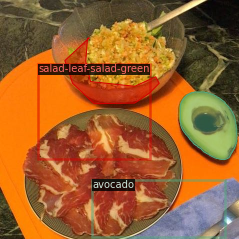

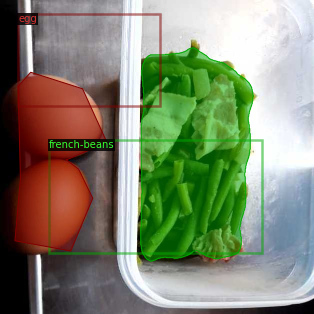

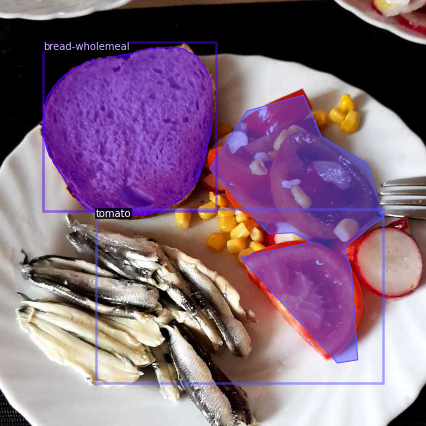

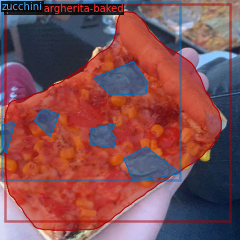

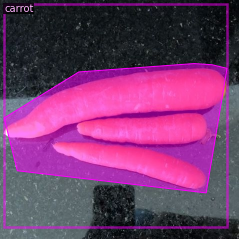

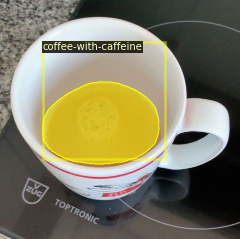

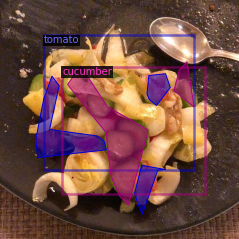

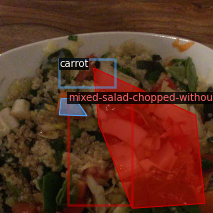

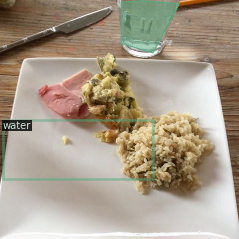

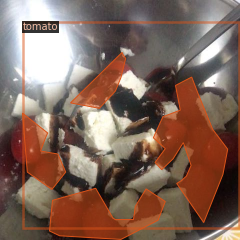

In [17]:
import random
# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer

for d in ["train", "val"]:
    register_coco_instances(d, {}, "./data/"+d+"/annotations.json", "./data/"+d+"/images")
    cricket_bat_metadata = MetadataCatalog.get(d)
    dataset_dicts = DatasetCatalog.get(d)

dataset_dicts = DatasetCatalog.get('train')
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=cricket_bat_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

#Training

In [24]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
import os

cfg = get_cfg()
cfg.merge_from_file(
    "./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
cfg.DATASETS.TRAIN = ("train3",)
cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
cfg.MODEL.DEVICE = "cuda" # "cuda" for gpu
cfg.DATALOADER.NUM_WORKERS = 10
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = (
    500
)  # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    128
)  # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 62  # 62 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/31 10:59:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[07/31 10:59:11 d2.engine.train_loop]: Starting training from iteration 0
[07/31 10:59:31 d2.utils.events]:  eta: 0:07:19  iter: 19  total_loss: 4.657  loss_cls: 3.235  loss_box_reg: 0.567  loss_mask: 0.691  loss_rpn_cls: 0.018  loss_rpn_loc: 0.015  time: 0.9201  data_time: 0.0616  lr: 0.000400  max_mem: 4986M
[07/31 10:59:49 d2.utils.events]:  eta: 0:07:03  iter: 39  total_loss: 2.092  loss_cls: 0.834  loss_box_reg: 0.522  loss_mask: 0.684  loss_rpn_cls: 0.025  loss_rpn_loc: 0.011  time: 0.9274  data_time: 0.0074  lr: 0.000799  max_mem: 4986M
[07/31 11:00:08 d2.utils.events]:  eta: 0:06:43  iter: 59  total_loss: 2.124  loss_cls: 0.855  loss_box_reg: 0.584  loss_mask: 0.639  loss_rpn_cls: 0.011  loss_rpn_loc: 0.010  time: 0.9261  data_time: 0.0077  lr: 0.001199  max_mem: 4986M
[07/31 11:00:27 d2.utils.events]:  eta: 0:06:31  iter: 79  total_loss: 2.076  loss_cls: 0.886  loss_box_reg: 0.659  loss_mask: 0.619  loss_rpn_cls: 0.010  loss_rpn_loc: 0.010  time: 0.9345  data_time: 0.0072  lr:

#Validation

In [25]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("val", )
predictor = DefaultPredictor(cfg)

WARNING [07/31 11:26:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/31 11:26:29 d2.data.datasets.coco]: Loaded 291 images in COCO format from ./data/val/annotations.json


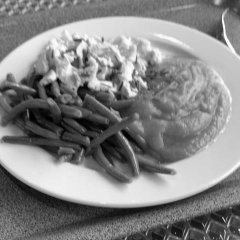

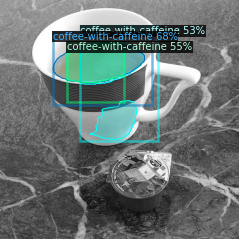

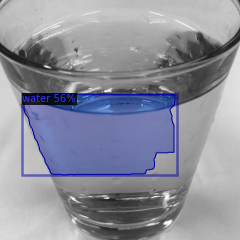

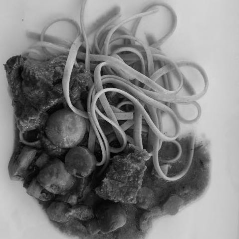

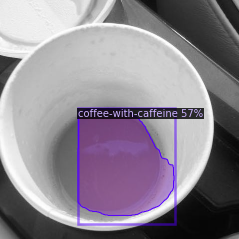

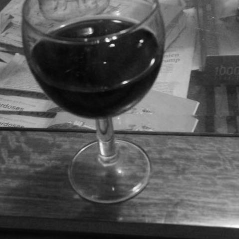

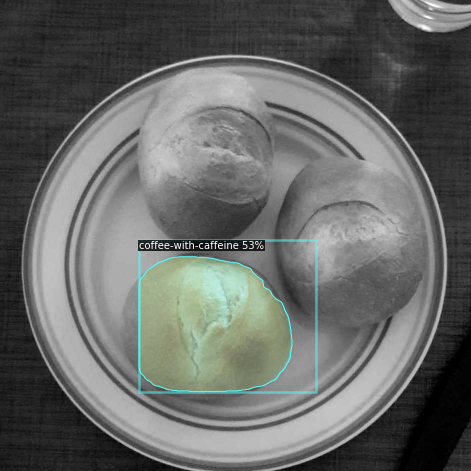

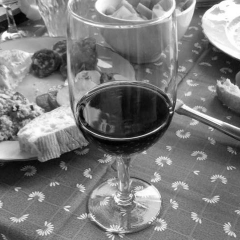

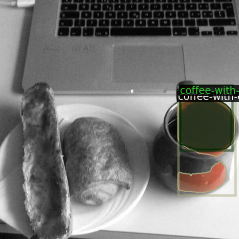

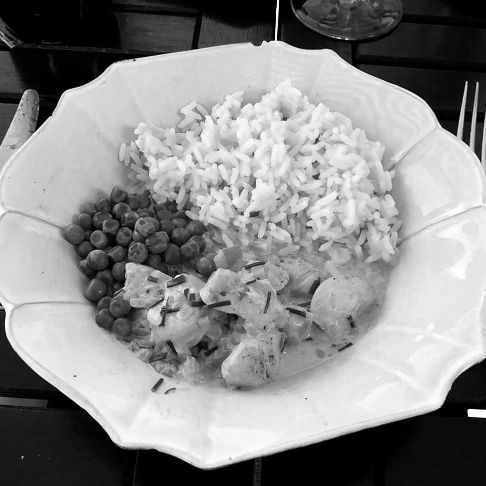

In [26]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get('val')
for d in random.sample(dataset_dicts, 10):
# for d in dataset_dicts:    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=cricket_bat_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

#Calculate AP

In [27]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way is to use trainer.test

WARNING [07/31 11:26:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/31 11:26:48 d2.data.datasets.coco]: Loaded 291 images in COCO format from ./data/val/annotations.json
[07/31 11:26:48 d2.data.common]: Serializing 291 elements to byte tensors and concatenating them all ...
[07/31 11:26:48 d2.data.common]: Serialized dataset takes 1.14 MiB
[07/31 11:26:48 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/31 11:26:48 d2.evaluation.evaluator]: Start inference on 291 images
[07/31 11:26:53 d2.evaluation.evaluator]: Inference done 11/291. 0.2820 s / img. ETA=0:01:28
[07/31 11:26:58 d2.evaluation.evaluator]: Inference done 25/291. 0.2895 s / img. ETA=0:01:38
[07/31 11:27:03 d2.evaluation.evaluator]: Inference done 37/291. 0.2917 s / img. ETA=0:01:38
[07/31 11:27:08 d2.evaluation.evaluator]: Inference done 51/291. 0.2912

In [28]:
# Look at training curves in tensorboard:
# %load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir output

<IPython.core.display.Javascript object>